In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

class MoannaDataset(Dataset):
    def __init__(self, data_file, label_file):
        self.data = pd.read_csv(data_file, sep=',', header=0, index_col=0).values
        self.label = pd.read_csv(label_file, header=0, index_col=0).values[:,1]
        self.data = torch.from_numpy(self.data).float().to(device)
        self.label = self.label.astype(int)
        self.label = torch.from_numpy(self.label).long().to(device)

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]


class MoannaModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(MoannaModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        # out = self.batchnorm(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [2]:

data_file = '/home/intern/WarmUpProject/p-tcga_binary_mutation.csv'
label_file = '/home/intern/WarmUpProject/pp-TCGA-clinical.csv'

dataset = MoannaDataset(data_file, label_file)

batch_size = 128


In [3]:
idx = torch.randperm(len(dataset))

split_point = int(0.7 * len(idx))

train_idx = idx[:split_point]
test_idx = idx[split_point:]

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 


In [4]:
train_dataset.dataset.label

tensor([ 7,  7,  7,  ..., 28,  3,  2], device='cuda:0')

In [5]:
def k_fold_cross_validation(train_dataset, test_loader, k, num_epochs, batch_size, device, shuffle=True):
    
    n_samples = len(train_dataset)
    fold_size = n_samples // k
    indices = np.random.permutation(n_samples)

    Model = []
    
    for i in range(k):
        print(f"Processing fold {i+1}/{k}...")
        
        start = i * fold_size
        end = (i + 1) * fold_size
        
        traintrain_indices = np.concatenate([indices[:start], indices[end:]])
        trainval_indices = indices[start:end]
        
        # Create data loaders for training and validation
        traintrain_dataset = Subset(train_dataset, traintrain_indices)
        trainval_dataset = Subset(train_dataset, trainval_indices)
        traintrain_loader = DataLoader(traintrain_dataset, batch_size=batch_size, shuffle=shuffle)
        trainval_loader = DataLoader(trainval_dataset, batch_size=batch_size, shuffle=False)    
        
        # Hyperparameters
        learning_rate = 0.1
        hidden_dim = 128

        # Initialize model and transfer to GPU
        model = MoannaModel(train_dataset.data.shape[1], hidden_dim, 33).to(device)
        

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        
        # Train the model
        train_losses = []
        train_accs = []
        val_accs = []
        test_accs = []
        for epoch in range(num_epochs):
            # Train
            model.train()
            train_loss = 0.0
            train_acc = 0.0
            for j, (inputs, labels) in enumerate(traintrain_loader):
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())

            train_loss /= len(traintrain_loader)
            train_acc /= len(traintrain_loader)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            # Validate
            model.eval()
            val_acc = 0.0
            with torch.no_grad():
                for inputs, labels in trainval_loader:
                    outputs = model(inputs)
                    val_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())
                val_acc /= len(trainval_loader)
                val_accs.append(val_acc)

            # # Check if this is the best model so far
            # if val_acc > best_accuracy:
            #     best_accuracy = val_acc
            #     best_model = model.__class__(train_dataset.data.shape[1], hidden_dim, 33).to(device)
            #     best_model.load_state_dict(model.state_dict())
                
            # Test
            model.eval()
            test_acc = 0.0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    outputs = model(inputs)
                    test_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())
                test_acc /= len(test_loader)
                test_accs.append(test_acc)
                
            print(f"Fold {i+1}/{k}, Epoch {epoch+1}: Train Loss={train_loss:.4f}, "
                  f"Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Test Acc={test_acc:.4f}")
            
        MModel = model.__class__(train_dataset.data.shape[1], hidden_dim, 33).to(device)
        MModel.load_state_dict(model.state_dict())
        Model.append(MModel)
        
        # Plot loss and accuracy for this fold
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.legend()
        plt.title(f"Fold {i+1} Loss")

        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Train Acc')
        plt.plot(val_accs, label='Val Acc')
        plt.plot(test_accs, label='Test Acc')
        plt.legend()
        plt.title(f"Fold {i+1} Accuracy")
        plt.show()

    return Model

Processing fold 1/5...
Fold 1/5, Epoch 1: Train Loss=3.4128, Train Acc=0.0952, Val Acc=0.1562, Test Acc=0.1751
Fold 1/5, Epoch 2: Train Loss=3.2226, Train Acc=0.1630, Val Acc=0.1657, Test Acc=0.1872
Fold 1/5, Epoch 3: Train Loss=3.0780, Train Acc=0.1796, Val Acc=0.1878, Test Acc=0.2182
Fold 1/5, Epoch 4: Train Loss=2.9487, Train Acc=0.2036, Val Acc=0.1968, Test Acc=0.2387
Fold 1/5, Epoch 5: Train Loss=2.8340, Train Acc=0.2436, Val Acc=0.2518, Test Acc=0.2950
Fold 1/5, Epoch 6: Train Loss=2.7157, Train Acc=0.2828, Val Acc=0.2745, Test Acc=0.3313
Fold 1/5, Epoch 7: Train Loss=2.5959, Train Acc=0.3170, Val Acc=0.3146, Test Acc=0.3696
Fold 1/5, Epoch 8: Train Loss=2.4813, Train Acc=0.3489, Val Acc=0.3119, Test Acc=0.3748
Fold 1/5, Epoch 9: Train Loss=2.3750, Train Acc=0.3705, Val Acc=0.3227, Test Acc=0.4001
Fold 1/5, Epoch 10: Train Loss=2.2670, Train Acc=0.4095, Val Acc=0.3448, Test Acc=0.4565
Fold 1/5, Epoch 11: Train Loss=2.1813, Train Acc=0.4447, Val Acc=0.3828, Test Acc=0.5244
Fold 1/

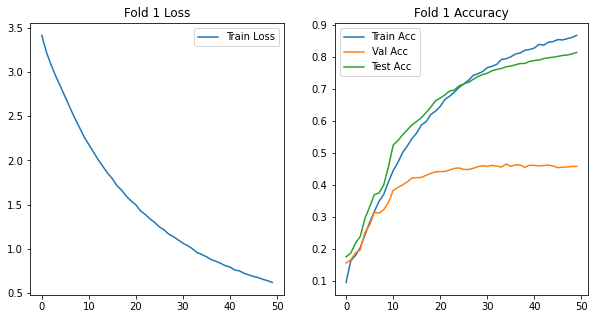

Processing fold 2/5...
Fold 2/5, Epoch 1: Train Loss=3.4080, Train Acc=0.1047, Val Acc=0.1431, Test Acc=0.1523
Fold 2/5, Epoch 2: Train Loss=3.2200, Train Acc=0.1568, Val Acc=0.1667, Test Acc=0.1889
Fold 2/5, Epoch 3: Train Loss=3.0678, Train Acc=0.1781, Val Acc=0.1828, Test Acc=0.2216
Fold 2/5, Epoch 4: Train Loss=2.9539, Train Acc=0.1984, Val Acc=0.1950, Test Acc=0.2429
Fold 2/5, Epoch 5: Train Loss=2.8271, Train Acc=0.2473, Val Acc=0.2294, Test Acc=0.2910
Fold 2/5, Epoch 6: Train Loss=2.7039, Train Acc=0.2908, Val Acc=0.2613, Test Acc=0.3388
Fold 2/5, Epoch 7: Train Loss=2.5778, Train Acc=0.3247, Val Acc=0.2803, Test Acc=0.3592
Fold 2/5, Epoch 8: Train Loss=2.4629, Train Acc=0.3475, Val Acc=0.2930, Test Acc=0.3835
Fold 2/5, Epoch 9: Train Loss=2.3577, Train Acc=0.3792, Val Acc=0.3066, Test Acc=0.4195
Fold 2/5, Epoch 10: Train Loss=2.2550, Train Acc=0.4164, Val Acc=0.3380, Test Acc=0.4672
Fold 2/5, Epoch 11: Train Loss=2.1600, Train Acc=0.4571, Val Acc=0.3583, Test Acc=0.4968
Fold 2/

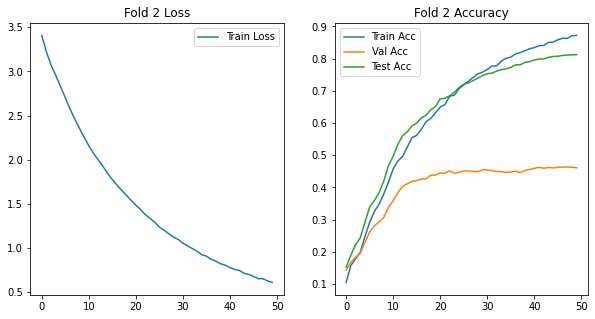

Processing fold 3/5...
Fold 3/5, Epoch 1: Train Loss=3.4019, Train Acc=0.1101, Val Acc=0.1473, Test Acc=0.1572
Fold 3/5, Epoch 2: Train Loss=3.2093, Train Acc=0.1574, Val Acc=0.1797, Test Acc=0.2109
Fold 3/5, Epoch 3: Train Loss=3.0722, Train Acc=0.1802, Val Acc=0.1909, Test Acc=0.2244
Fold 3/5, Epoch 4: Train Loss=2.9512, Train Acc=0.2046, Val Acc=0.2079, Test Acc=0.2492
Fold 3/5, Epoch 5: Train Loss=2.8265, Train Acc=0.2417, Val Acc=0.2491, Test Acc=0.3034
Fold 3/5, Epoch 6: Train Loss=2.7019, Train Acc=0.2876, Val Acc=0.2872, Test Acc=0.3427
Fold 3/5, Epoch 7: Train Loss=2.5813, Train Acc=0.3206, Val Acc=0.3047, Test Acc=0.3667
Fold 3/5, Epoch 8: Train Loss=2.4594, Train Acc=0.3480, Val Acc=0.3149, Test Acc=0.3992
Fold 3/5, Epoch 9: Train Loss=2.3526, Train Acc=0.3830, Val Acc=0.3305, Test Acc=0.4306
Fold 3/5, Epoch 10: Train Loss=2.2435, Train Acc=0.4191, Val Acc=0.3492, Test Acc=0.4696
Fold 3/5, Epoch 11: Train Loss=2.1657, Train Acc=0.4501, Val Acc=0.3768, Test Acc=0.5174
Fold 3/

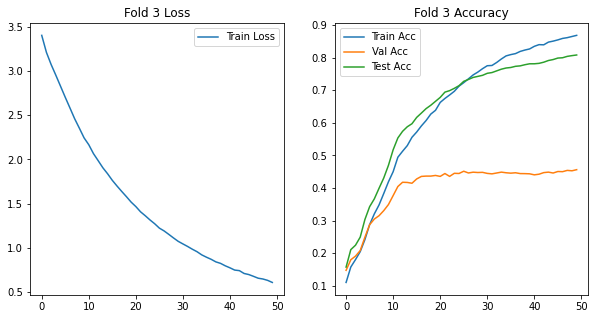

Processing fold 4/5...
Fold 4/5, Epoch 1: Train Loss=3.4072, Train Acc=0.1036, Val Acc=0.1438, Test Acc=0.1562
Fold 4/5, Epoch 2: Train Loss=3.2119, Train Acc=0.1542, Val Acc=0.1572, Test Acc=0.1850
Fold 4/5, Epoch 3: Train Loss=3.0749, Train Acc=0.1722, Val Acc=0.1750, Test Acc=0.2053
Fold 4/5, Epoch 4: Train Loss=2.9519, Train Acc=0.2028, Val Acc=0.2080, Test Acc=0.2479
Fold 4/5, Epoch 5: Train Loss=2.8368, Train Acc=0.2332, Val Acc=0.2182, Test Acc=0.2651
Fold 4/5, Epoch 6: Train Loss=2.7176, Train Acc=0.2704, Val Acc=0.2718, Test Acc=0.3155
Fold 4/5, Epoch 7: Train Loss=2.6052, Train Acc=0.3145, Val Acc=0.3000, Test Acc=0.3492
Fold 4/5, Epoch 8: Train Loss=2.4873, Train Acc=0.3438, Val Acc=0.3187, Test Acc=0.3714
Fold 4/5, Epoch 9: Train Loss=2.3791, Train Acc=0.3731, Val Acc=0.3304, Test Acc=0.4115
Fold 4/5, Epoch 10: Train Loss=2.2756, Train Acc=0.4120, Val Acc=0.3529, Test Acc=0.4526
Fold 4/5, Epoch 11: Train Loss=2.1795, Train Acc=0.4393, Val Acc=0.3806, Test Acc=0.4955
Fold 4/

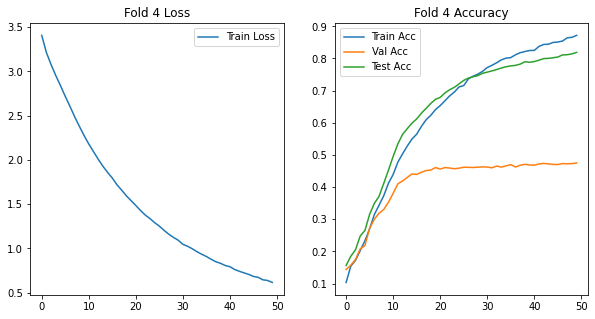

Processing fold 5/5...
Fold 5/5, Epoch 1: Train Loss=3.4061, Train Acc=0.1067, Val Acc=0.1578, Test Acc=0.1631
Fold 5/5, Epoch 2: Train Loss=3.2084, Train Acc=0.1555, Val Acc=0.1815, Test Acc=0.1979
Fold 5/5, Epoch 3: Train Loss=3.0672, Train Acc=0.1797, Val Acc=0.1811, Test Acc=0.2085
Fold 5/5, Epoch 4: Train Loss=2.9443, Train Acc=0.2054, Val Acc=0.2115, Test Acc=0.2492
Fold 5/5, Epoch 5: Train Loss=2.8279, Train Acc=0.2404, Val Acc=0.2459, Test Acc=0.3014
Fold 5/5, Epoch 6: Train Loss=2.7086, Train Acc=0.2933, Val Acc=0.2833, Test Acc=0.3391
Fold 5/5, Epoch 7: Train Loss=2.5826, Train Acc=0.3273, Val Acc=0.3096, Test Acc=0.3634
Fold 5/5, Epoch 8: Train Loss=2.4699, Train Acc=0.3502, Val Acc=0.3184, Test Acc=0.3818
Fold 5/5, Epoch 9: Train Loss=2.3548, Train Acc=0.3830, Val Acc=0.3353, Test Acc=0.4258
Fold 5/5, Epoch 10: Train Loss=2.2583, Train Acc=0.4190, Val Acc=0.3499, Test Acc=0.4494
Fold 5/5, Epoch 11: Train Loss=2.1674, Train Acc=0.4445, Val Acc=0.3823, Test Acc=0.5111
Fold 5/

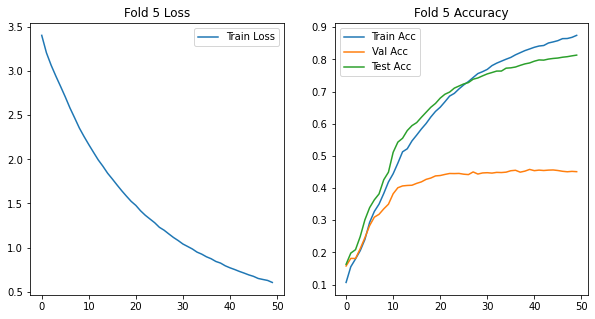

In [6]:
num_epochs = 50
k = 5

Model = k_fold_cross_validation(train_dataset.dataset, test_loader, k, num_epochs, batch_size, device=device, shuffle=True)

In [7]:
Model

[MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=12

In [8]:
def test_model(model, test_loader):
    model.eval()
    test_acc = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            test_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())

        test_acc /= len(test_loader)

    print(f"Test Accuracy: {test_acc:.4f}")

In [9]:
for i in range(5):
    test_model(Model[i], test_loader)

Test Accuracy: 0.8144
Test Accuracy: 0.8126
Test Accuracy: 0.8083
Test Accuracy: 0.8188
Test Accuracy: 0.8133


In [10]:
for inputs, labels in train_loader:
    outputs = Model[1](inputs)
    print(torch.argmax(outputs, dim=1))
    print(labels)

tensor([ 2,  1, 21, 27, 10, 27, 27, 15,  0,  1, 27, 18, 16,  2,  4, 22, 18,  7,
         8, 27, 18, 11,  1, 25, 27, 15, 21, 18, 13, 19,  1,  2, 13,  1, 14, 24,
         7, 14, 16, 21, 15, 14, 13, 15, 14,  0,  1,  8, 10,  1, 18, 29,  8, 15,
         8,  6,  1, 29,  6,  6,  8, 14, 10, 27, 16, 11,  1,  4, 29, 27,  8, 30,
         4, 13, 14, 24,  0,  4, 14,  8,  1, 15, 10,  1, 19, 15,  0,  1,  8,  0,
         7, 11,  4,  1,  8, 14, 24, 27, 24, 27, 16, 27, 21, 15,  7, 29,  8, 13,
         7, 21,  0, 18, 27,  1, 27, 24, 21,  2, 11,  7, 22,  8, 29, 14,  1, 15,
        27, 10], device='cuda:0')
tensor([ 2,  1, 21, 20, 10, 26, 27, 15,  0,  1, 27, 18, 16, 32,  4, 22, 18,  7,
         8, 26, 18, 11,  1, 25,  9, 15, 23, 29, 13, 19,  1,  2, 13,  1, 14, 24,
         7, 14, 16, 21, 15, 14, 13, 15, 14, 10,  1,  8, 10,  1, 18, 29,  8, 15,
         8,  6,  1, 29, 14,  6,  8, 14, 10, 11, 16, 11,  1,  4, 29, 27,  8, 30,
         4, 13, 14, 24,  0,  4, 29,  8,  1, 15, 10,  1, 19, 15,  0,  1,  8,  0,
      